Import Packages

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

Select the Graph You Want

In [2]:
aalborg_clear = ox.load_graphml('aalborg_network_nodes_data.graphml')

In [15]:
def verify_time_series_data(graph, label, search_on='edges'):
    """
    Verifies time series data in a graph by counting elements with assigned, non-empty data
    and checking for any missing or empty data entries.

    Parameters:
    - graph: The input graph.
    - label: The label to search for in the graph attributes (e.g., 'time_series_data').
    - search_on: Specify whether to search on 'edges' or 'nodes'.

    Prints verification results.
    """
    def has_meaningful_data(value):
        """Helper function to check if a value is non-empty and meaningful."""
        if value is None:
            return False
        elif isinstance(value, dict):
            return bool(value)  # Non-empty dictionary
        elif isinstance(value, list):
            return any(item is not None for item in value)  # List with at least one non-None item
        else:
            return True  # Non-empty, non-None value

    if search_on == 'edges':
        elements = graph.edges(data=True)
    elif search_on == 'nodes':
        elements = graph.nodes(data=True)
    else:
        raise ValueError("search_on parameter must be 'edges' or 'nodes'")

    # Count elements with and without meaningful time series data
    if search_on == 'edges':
        with_data = sum(1 for _, _, data in elements if label in data and has_meaningful_data(data[label]))
        missing_data_elements = [(u, v) for u, v, data in elements if label not in data or not has_meaningful_data(data[label])]
    else:  # search_on == 'nodes'
        with_data = sum(1 for _, data in elements if label in data and has_meaningful_data(data[label]))
        missing_data_elements = [u for u, data in elements if label not in data or not has_meaningful_data(data[label])]

    total_elements = len(elements)

    # Print verification results
    print(f"Total {search_on} in graph: {total_elements}")
    print(f"{search_on.capitalize()} with meaningful {label}: {with_data}")

    if with_data == total_elements:
        print(f"Verification complete: All {search_on} have meaningful {label}.")
    else:
        print(f"Verification complete: {total_elements - with_data} {search_on} are missing or have empty {label}.")
        print(f"Missing or empty data {search_on}: {missing_data_elements}")


def filter_graph_within_hops(graph, data_attr='time_series_data', hop_count=20, data_on='edges'):
    """
    Filters a graph to retain only nodes and edges within a specified number of hops from elements with specified data.
    
    Parameters:
        graph (networkx.MultiGraph): The input graph.
        data_attr (str): The attribute name to look for time series data (default is 'time_series_data').
        hop_count (int): The number of hops from each node or edge containing data to retain (default is 6).
        data_on (str): Specify 'nodes' if data is on nodes, or 'edges' if data is on edges (default is 'edges').

    Returns:
        networkx.MultiGraph: The filtered subgraph.
    """
    
    # Identify elements with the specified data attribute
    if data_on == 'edges':
        elements_with_data = [
            (u, v, key) for u, v, key, data in graph.edges(keys=True, data=True)
            if data_attr in data and data[data_attr]
        ]
    elif data_on == 'nodes':
        elements_with_data = [
            node for node, data in graph.nodes(data=True)
            if data_attr in data and data[data_attr]
        ]
    else:
        raise ValueError("Invalid value for 'data_on'. Use 'nodes' or 'edges'.")

    # Use BFS to find nodes within the specified hop count
    elements_to_keep = set()
    if data_on == 'edges':
        for u, v, key in elements_with_data:
            # Find nodes within the hop count from both ends of the edge
            nodes_within_hops = set(nx.single_source_shortest_path_length(graph, u, cutoff=hop_count).keys())
            nodes_within_hops.update(nx.single_source_shortest_path_length(graph, v, cutoff=hop_count).keys())
            
            # Add edges connected to these nodes within the graph
            for node in nodes_within_hops:
                for neighbor in graph.neighbors(node):
                    for k in graph[node][neighbor]:  # Include all multiedges
                        elements_to_keep.add((node, neighbor, k))
                        
    elif data_on == 'nodes':
        for node in elements_with_data:
            # Find all nodes within the specified hop count
            nodes_within_hops = nx.single_source_shortest_path_length(graph, node, cutoff=hop_count).keys()
            
            # Add edges connected to these nodes
            for node_within_hop in nodes_within_hops:
                for neighbor in graph.neighbors(node_within_hop):
                    for k in graph[node_within_hop][neighbor]:  # Include all multiedges
                        elements_to_keep.add((node_within_hop, neighbor, k))

    # Create a subgraph with only the elements within the specified hops
    graph_filtered = graph.edge_subgraph(elements_to_keep).copy()

    # Only keep the largest connected component
    graph_filtered = max(nx.connected_components(graph_filtered), key=len)


    # Convert to nodes and edges GeoDataFrames for further analysis if needed
    # nodes_filtered, edges_filtered = ox.graph_to_gdfs(graph_filtered, nodes=True, edges=True)

    # Display filtered graph summary
    print(f"Filtered graph contains {graph_filtered.number_of_nodes()} nodes and {graph_filtered.number_of_edges()} edges.")
    
    return graph_filtered #, nodes_filtered, edges_filtered

def plot_graph_with_data_highlight(G_proj, mode="node", save=False):
    """
    Plots the graph, highlighting nodes or edges that contain time-series data.
    
    Parameters:
        G_proj (networkx.MultiDiGraph): The graph to plot.
        mode (str): The mode to highlight, either "node" or "edge".
    """
    # Define colors and widths for nodes or edges based on presence of time-series data
    if mode == "node":
        node_colors = ["red" if "time_series_data" in data else "black" for _, data in G_proj.nodes(data=True)]
        node_sizes = [5 if "time_series_data" in data else 0.5 for _, data in G_proj.nodes(data=True)]
        
        # Plot the graph with osmnx
        fig, ax = ox.plot_graph(
            G_proj,
            node_color=node_colors,
            node_size=node_sizes,
            edge_linewidth=0.5,
            edge_color="black",
            figsize=(12, 12),
            bgcolor="white"
        )
        # Set the plot title for nodes
        ax.set_title("Street Network with Nodes Containing Time Series Data Highlighted in Red", fontsize=15)

    elif mode == "edge":
        edge_colors = ["red" if "time_series_data" in data else "black" for _, _, data in G_proj.edges(data=True)]
        edge_widths = [2 if "time_series_data" in data else 0.5 for _, _, data in G_proj.edges(data=True)]
        
        # Plot the graph with osmnx
        fig, ax = ox.plot_graph(
            G_proj,
            node_size=0,  # Hide nodes if not highlighting nodes
            edge_color=edge_colors,
            edge_linewidth=edge_widths,
            figsize=(12, 12),
            bgcolor="white"
        )
        # Set the plot title for edges
        ax.set_title("Street Network with Edges Containing Time Series Data Highlighted in Red", fontsize=15)

    else:
        raise ValueError("Invalid mode. Choose 'node' or 'edge'.")

    if save:
        plt.savefig(f"street_network_{mode}_highlighted.png", dpi=300, bbox_inches="tight")

    plt.show()


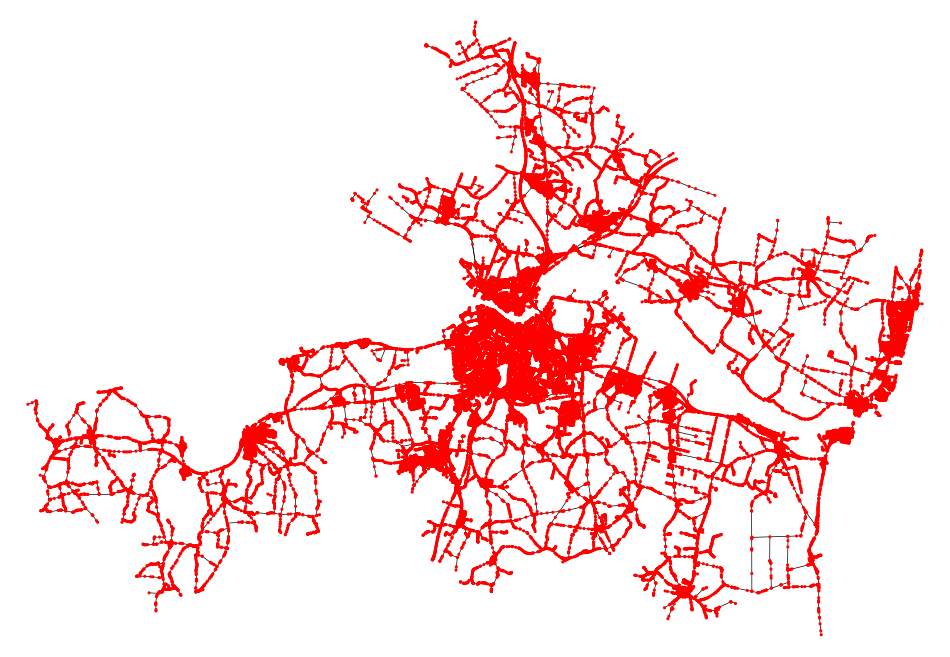

In [11]:
plot_graph_with_data_highlight(aalborg_clear, mode="node")

In [17]:
verify_time_series_data(aalborg_clear, 'time_series_data', search_on='nodes')

Total nodes in graph: 67204
Nodes with meaningful time_series_data: 67204
Verification complete: All nodes have meaningful time_series_data.


In [7]:
for node, data in aalborg_clear.nodes(data=True):
    if 'time_series_data' in data and data['time_series_data'] != None:
        print(node,data['time_series_data'])
        break



27462734 None
